Feature Summary Statistics:
                          count        mean         std     min       25%  \
Pregnancies               768.0    3.845052    3.369578   0.000   1.00000   
Glucose                   768.0  120.894531   31.972618   0.000  99.00000   
BloodPressure             768.0   69.105469   19.355807   0.000  62.00000   
SkinThickness             768.0   20.536458   15.952218   0.000   0.00000   
Insulin                   768.0   79.799479  115.244002   0.000   0.00000   
BMI                       768.0   31.992578    7.884160   0.000  27.30000   
DiabetesPedigreeFunction  768.0    0.471876    0.331329   0.078   0.24375   
Age                       768.0   33.240885   11.760232  21.000  24.00000   

                               50%        75%     max  
Pregnancies                 3.0000    6.00000   17.00  
Glucose                   117.0000  140.25000  199.00  
BloodPressure              72.0000   80.00000  122.00  
SkinThickness              23.0000   32.00000   99.00 

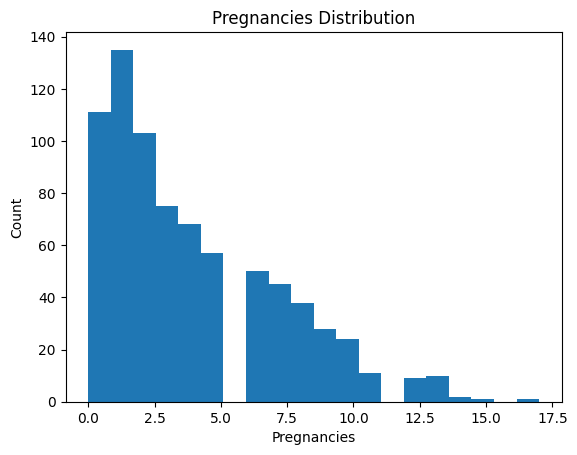

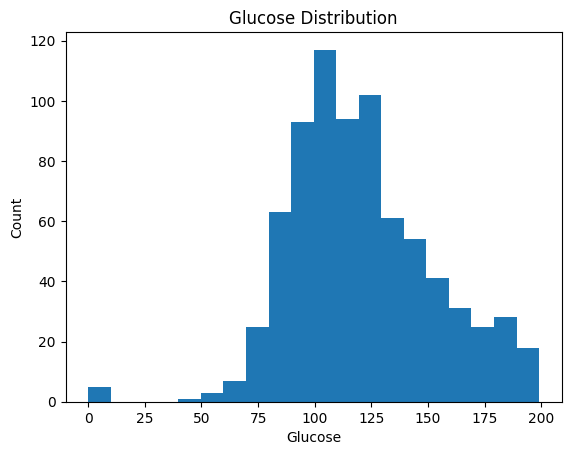

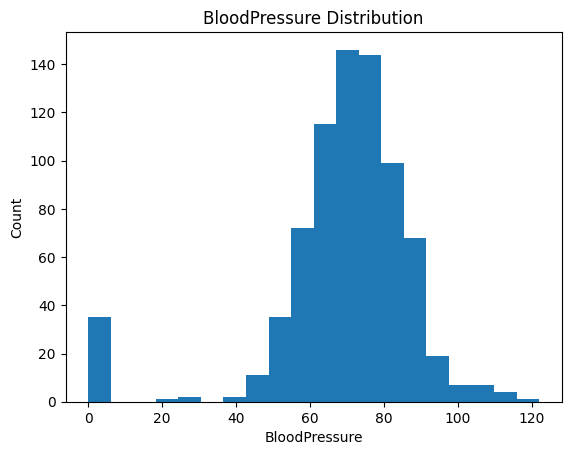

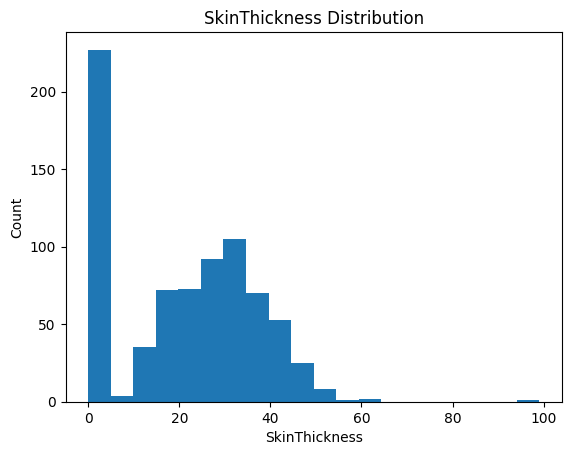

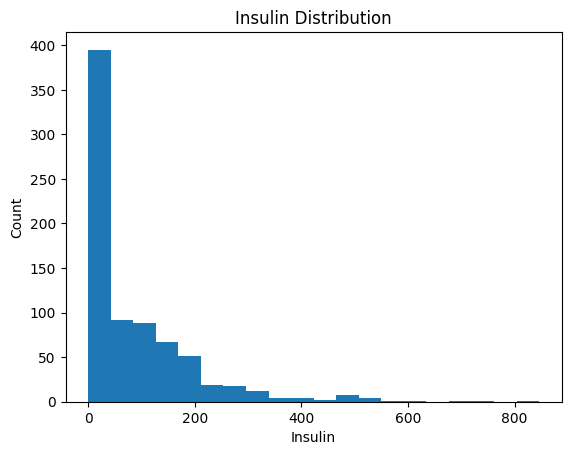

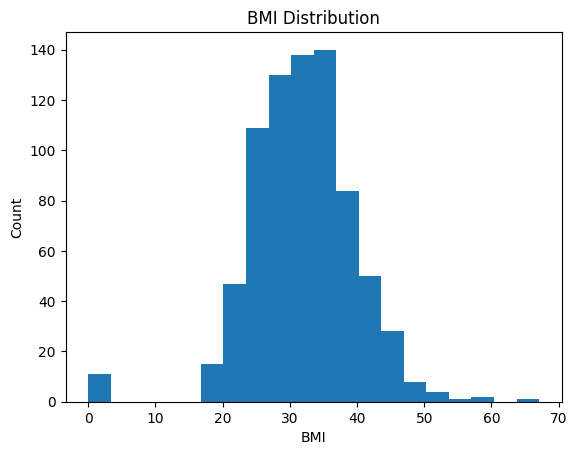

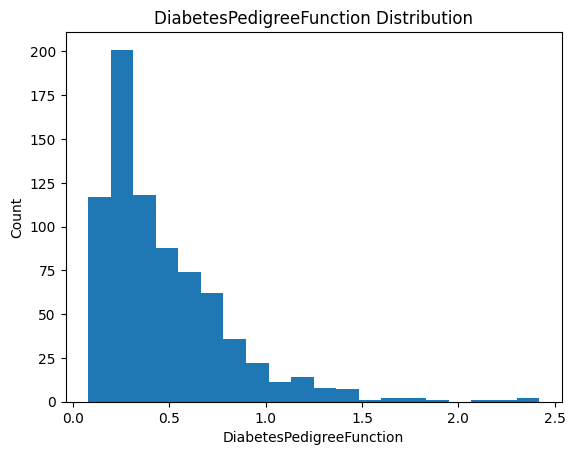

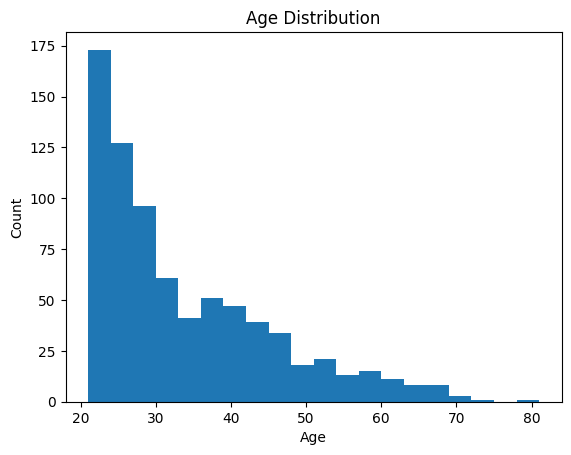


Model Metrics Comparison:
     Model  AUC (2016→2017)  AUC (2017→2017)  LogLoss (2016→2017)  \
0   LogReg         0.860200         0.862848             0.451381   
1  DecTree         0.779834         0.951157             3.446618   

   LogLoss (2017→2017)  AUC Diff  p-value  
0             0.436164  0.002648    0.342  
1             0.250192  0.171324    0.000  


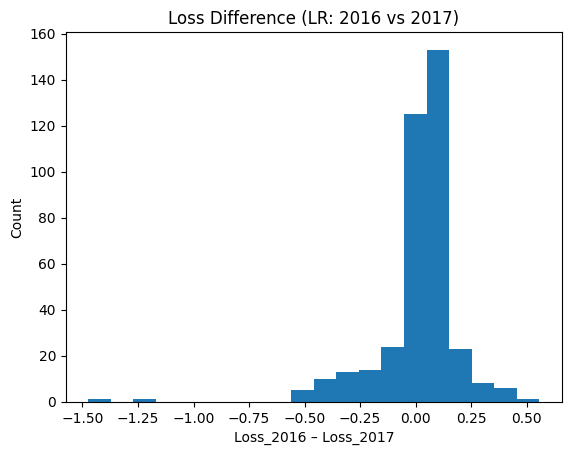


Subpopulation Discovery Rules (LogReg):
|--- Age <= 29.50
|   |--- Glucose <= 124.50
|   |   |--- BloodPressure <= 49.00
|   |   |   |--- class: 1
|   |   |--- BloodPressure >  49.00
|   |   |   |--- class: 1
|   |--- Glucose >  124.50
|   |   |--- SkinThickness <= 38.50
|   |   |   |--- class: 1
|   |   |--- SkinThickness >  38.50
|   |   |   |--- class: 0
|--- Age >  29.50
|   |--- BMI <= 25.30
|   |   |--- Age <= 70.50
|   |   |   |--- class: 1
|   |   |--- Age >  70.50
|   |   |   |--- class: 0
|   |--- BMI >  25.30
|   |   |--- DiabetesPedigreeFunction <= 0.72
|   |   |   |--- class: 1
|   |   |--- DiabetesPedigreeFunction >  0.72
|   |   |   |--- class: 0


Ablation Study: C vs. AUC (LogReg):
        C  AUC (2016→2017)
0    0.01         0.856742
1    0.10         0.860854
2    1.00         0.860200
3   10.00         0.857708
4  100.00         0.857646


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import roc_auc_score, log_loss

# 1. Load Pima Indians Diabetes dataset (public CSV)
url = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"
df = pd.read_csv(url)

# 2. Prepare features and target
features = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']
df = df.dropna(subset=features + ['Outcome'])
df['outcome'] = df['Outcome']  # binary target: 0 or 1

# 3. Assign synthetic 'year' by splitting equally
n = len(df)
df = df.reset_index(drop=True)
df['year'] = [2016 if i < n//2 else 2017 for i in range(n)]

# 4. Feature summary
print("Feature Summary Statistics:")
print(df[features].describe().T)

# 5. Plot feature distributions
for feat in features:
    plt.figure()
    plt.hist(df[feat], bins=20)
    plt.title(f'{feat} Distribution')
    plt.xlabel(feat)
    plt.ylabel('Count')
    plt.show()

# 6. Split into 2016 train and 2017 test
train = df[df['year'] == 2016]
test  = df[df['year'] == 2017]
X_train, y_train = train[features], train['outcome']
X_test,  y_test  = test[features],  test['outcome']

# 7. Train models
lr16 = LogisticRegression(max_iter=1000)
lr16.fit(X_train, y_train)
p_lr16 = lr16.predict_proba(X_test)[:,1]

dt16 = DecisionTreeClassifier(max_depth=5)
dt16.fit(X_train, y_train)
p_dt16 = dt16.predict_proba(X_test)[:,1]

lr17 = LogisticRegression(max_iter=1000)
lr17.fit(X_test, y_test)
p_lr17 = lr17.predict_proba(X_test)[:,1]

dt17 = DecisionTreeClassifier(max_depth=5)
dt17.fit(X_test, y_test)
p_dt17 = dt17.predict_proba(X_test)[:,1]

# 8. Metrics computation
def compute_metrics(y, p_prev, p_curr, perms=500):
    auc_prev = roc_auc_score(y, p_prev)
    auc_curr = roc_auc_score(y, p_curr)
    loss_prev = log_loss(y, p_prev)
    loss_curr = log_loss(y, p_curr)
    auc_diff = auc_curr - auc_prev
    perm = []
    for _ in range(perms):
        y_perm = np.random.permutation(y)
        perm.append(roc_auc_score(y_perm, p_curr) - roc_auc_score(y_perm, p_prev))
    p_val = np.mean([d >= auc_diff for d in perm])
    return auc_prev, auc_curr, loss_prev, loss_curr, auc_diff, p_val

results = []
for name, pp16, pp17 in [
    ('LogReg', p_lr16, p_lr17),
    ('DecTree', p_dt16, p_dt17)
]:
    auc1, auc2, l1, l2, diff, pval = compute_metrics(y_test, pp16, pp17)
    results.append({
        'Model': name,
        'AUC (2016→2017)': auc1,
        'AUC (2017→2017)': auc2,
        'LogLoss (2016→2017)': l1,
        'LogLoss (2017→2017)': l2,
        'AUC Diff': diff,
        'p-value': pval
    })

metrics_df = pd.DataFrame(results)
print("\nModel Metrics Comparison:")
print(metrics_df)

# 9. Loss difference histogram (Logistic Regression)
loss_diff = (
    -(y_test*np.log(p_lr16)+(1-y_test)*np.log(1-p_lr16))
    - (-(y_test*np.log(p_lr17)+(1-y_test)*np.log(1-p_lr17)))
)
plt.figure()
plt.hist(loss_diff, bins=20)
plt.title('Loss Difference (LR: 2016 vs 2017)')
plt.xlabel('Loss_2016 – Loss_2017')
plt.ylabel('Count')
plt.show()

# 10. Subpopulation analysis (Loss diff label)
label = ((
    -(y_test*np.log(p_lr16)+(1-y_test)*np.log(1-p_lr16))
    - (-(y_test*np.log(p_lr17)+(1-y_test)*np.log(1-p_lr17)))
) > 0).astype(int)
dt_sub = DecisionTreeClassifier(max_depth=3)
dt_sub.fit(X_test, label)
print("\nSubpopulation Discovery Rules (LogReg):")
print(export_text(dt_sub, feature_names=features))

# 11. Ablation: regularization strength
Cs = [0.01, 0.1, 1, 10, 100]
ablation = []
for C in Cs:
    lr = LogisticRegression(C=C, max_iter=1000)
    lr.fit(X_train, y_train)
    auc_val = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
    ablation.append({'C': C, 'AUC (2016→2017)': auc_val})
ablation_df = pd.DataFrame(ablation)
print("\nAblation Study: C vs. AUC (LogReg):")
print(ablation_df)
